## Purpose
This notebook explores the connection between well age and status. We will examine both construction year and date recorded with the goal of finding features that provide predictive power. 

Table of Contents
1. Initial EDA
2. Date Recorded
3. Construction Year
4. Age
5. Results

## 1. Initial EDA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_csv('../data/train_data.csv')
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
y_train = pd.read_csv('../data/train_targets.csv')
y_train

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [4]:
df = X_train.merge(y_train, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## 2. Date Recorded:
date_recorded - According the the DrivenData [website](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/), date_recorded refers to the day on which the row was entered into the database. 

Convert to datetime object to perform some descriptive statistics

In [5]:
df['date_recorded'] = pd.to_datetime(df.date_recorded, yearfirst=True)

In [6]:
df.date_recorded.describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

#### Convert to a float so that the describe method will provide quartiles and averages

In [7]:
def month_year_float(date_time):
    """
    converts a datetime object to a float where whole numbers represent years
    and the month is converted to a fraction of a year and added as a decimal.
    """
    return date_time.year + (date_time.month-1)/12

In [8]:
recorded_year_month = df.date_recorded.map(lambda x: month_year_float(x))

In [9]:
recorded_year_month.describe()

count    59400.000000
mean      2012.202970
std          0.913521
min       2002.750000
25%       2011.250000
50%       2012.750000
75%       2013.083333
max       2013.916667
Name: date_recorded, dtype: float64

#### Most records were taken between 2011 and 2013 but some were taken in 2002. Here's a distribution to see how the dates compare.

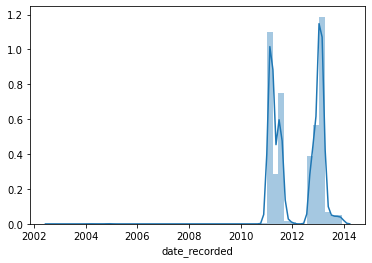

In [10]:
sns.distplot(recorded_year_month)

It looks like many records were taken in early 2011 and 2012. These could indicate seasonal data collection schedules by the government, or they could represent seasonal waterpoint damage reports by taarifa.

### Do we have multiple records for a single well?
This is important because it would allow us to zero in on the date at which the well became nonfunctional. We would need to find a unique identifier for each well to determine if the same well shows up more than once. There is no information on whether the id column indicates the id of the record or of the well, but if there are multiple records for each id then it is likely indicating the well. We can test this by checking how many unique values are in the id column. If it does not match the length of the dataframe, then it might be safe to assume that each id represents a well. If it does not match, then we still do not know either way.

In [11]:
len(df.id) == len(df)

True

#### If the id does not indicate an individual well, we'll look at the waterpoint name column 'wpt_name'. We'll look at the top 45 values to get an idea of how these waterpoints are named.

In [12]:
df.wpt_name.value_counts()[:45]

none                 3563
Shuleni              1748
Zahanati              830
Msikitini             535
Kanisani              323
Bombani               271
Sokoni                260
Ofisini               254
School                208
Shule Ya Msingi       199
Shule                 152
Sekondari             146
Muungano              133
Mkombozi              111
Madukani              104
Hospital               94
Mbugani                94
Upendo                 93
Kituo Cha Afya         90
Mkuyuni                88
Umoja                  84
Center                 83
Ccm                    81
Kisimani               78
Ofisi Ya Kijiji        76
Mtakuja                76
Tankini                73
Songambele             66
Bwawani                66
Maendeleo              64
Bondeni                61
Mbuyuni                59
Uwanjani               57
Kilabuni               55
Mnadani                52
Kijiweni               51
Secondary              49
Miembeni               49
Rc Church   

#### It looks like these names do not indicate unique waterpoints due to the fact that some are named Church, Hospital, or School with no specificity as to which location. As of right now, we do not know of any unique well identifiers.

# 3. Construction Year
If wells are not properly maintained then we can expect that they will be less likely to be functional they older they get.
First, let's take a look at the values in our construction_year column.

In [13]:
df.construction_year.value_counts()[:10]

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

#### We have many zero values which probably means that the value was not recorded. Here is the percentage of entries that lack a construction year.

In [14]:
(len(df[df.construction_year == 0])/(len(df)))*100

34.86363636363636

#### 35% of our data is missing construction year, which is a significant portion. For the purposes of this notebook we will exclude construction year. We will explore options for imputing these values later on.

In [15]:
has_year = df[df['construction_year'] !=0]

In [16]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [17]:
has_year = df[df['construction_year'] !=0].copy()
has_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38691 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     38691 non-null  int64         
 1   amount_tsh             38691 non-null  float64       
 2   date_recorded          38691 non-null  datetime64[ns]
 3   funder                 37350 non-null  object        
 4   gps_height             38691 non-null  int64         
 5   installer              37345 non-null  object        
 6   longitude              38691 non-null  float64       
 7   latitude               38691 non-null  float64       
 8   wpt_name               38691 non-null  object        
 9   num_private            38691 non-null  int64         
 10  basin                  38691 non-null  object        
 11  subvillage             38681 non-null  object        
 12  region                 38691 non-null  object        
 13  r

## 4. Age
Because the records were taken at different times, it would be more accurate to calculate the age of each well. To get the age of the well we will subtract the construction year from the date record.

In [18]:
has_year['age'] = has_year.date_recorded.map(lambda x: x.year) - has_year.construction_year

In [19]:
has_year.age.value_counts()

 3     2740
 1     2303
 2     2129
 5     1980
 4     1890
 13    1869
 7     1404
 6     1381
 11    1352
 14    1160
 8     1160
 33    1120
 15     993
 23     905
 10     868
 16     826
 9      814
 19     766
 27     762
 18     754
 28     709
 31     709
 35     647
 17     636
 39     601
 37     600
 26     589
 0      588
 25     583
 21     578
 29     564
 12     559
 20     541
 41     488
 30     359
 43     356
 38     351
 36     325
 22     323
 24     261
 40     233
 34     184
 32     174
 53      91
 42      90
 50      84
 45      66
 46      48
 44      47
 48      41
 51      31
 49      25
 47      14
 52      11
-5        3
-4        2
-7        1
-3        1
-2        1
-1        1
Name: age, dtype: int64

#### Because of the negative values at the bottom of the list above, one of our columns is not accurate. Because these negative values represent such a small proportion of our dataset, we will drop them for the purposes of this analysis.

In [20]:
has_year = has_year[has_year['age']>0]

#### Let's subset our data by the well status and see the age distributions for each one. If well age has an impact, we will likely see different distributions in each one. For simplicity, we will look only at functional and nonfucntional groups.

In [21]:
functional = has_year[has_year['status_group']=='functional']
non_functional =  has_year[has_year['status_group']=='non functional']

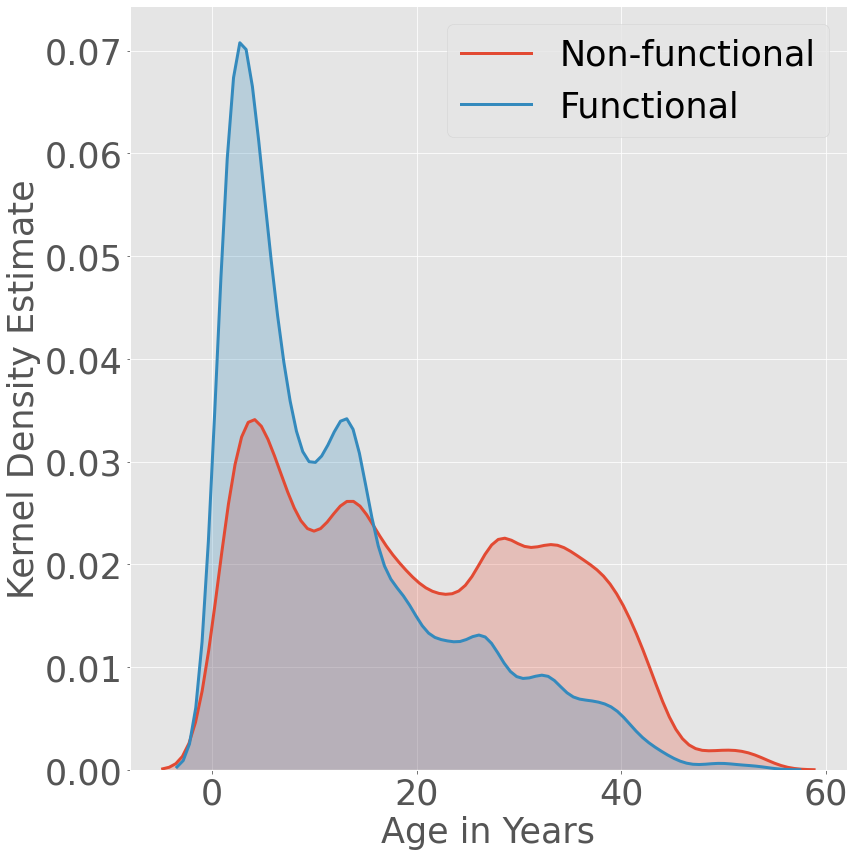

In [22]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1,1,figsize=(12,12))

sns.distplot(non_functional.age, ax=ax, label='Non-functional', hist=False, kde_kws = {'shade': True, 'linewidth': 3})
sns.distplot(functional.age, ax=ax, label='Functional', hist=False, kde_kws = {'shade': True, 'linewidth': 3})
ax.tick_params(axis='both', labelsize=35)
ax.set_xlabel('Age in Years', fontsize=35)
ax.set_ylabel('Kernel Density Estimate', fontsize=35)
plt.legend(loc='upper right', fontsize=35)

plt.tight_layout()
# plt.savefig('../reports/figures/age_dist.png', transparent=True)

#### The graph above shows a huge spike towards the left of te histogram, indicating a large portion of this subset is made up of relatively new wells between the ages of 0 and 10. The non-functional wells look to have a near uniform distribution with more non-functional than functional wells being between the ages of 25 and 45. Let's look at some descriptive statistics for each subset.

#### Functional Wells

In [23]:
functional.age.describe()

count    21287.000000
mean        12.409358
std         10.868796
min          1.000000
25%          4.000000
50%          9.000000
75%         18.000000
max         53.000000
Name: age, dtype: float64

#### Non Fucntional Wells

In [24]:
non_functional.age.describe()

count    14290.000000
mean        20.050665
std         13.182471
min          1.000000
25%          8.000000
50%         18.000000
75%         31.000000
max         53.000000
Name: age, dtype: float64

#### Difference between stats, positive number indicates a higher value for non-functional wells.

## 5. Results
#### Correlation
Let's see the correlation between age, construction year to see what kind of predicitve power they may have. First we'll need to convert the target to a numeric type. Because we still don't know the relationship between 'functional needs repair' and 'functional', we'll drop it from this part of the analysis.

In [25]:
has_year = has_year[has_year['status_group'] != 'functional needs repair']

In [26]:
status_code_numeric = {'functional': 0,
                      'non functional': 1}

has_year['status_code'] = has_year.status_group.replace(status_code_numeric)
has_year.status_code.value_counts()

0    21287
1    14290
Name: status_code, dtype: int64

In [27]:
has_year.loc[:,['age', 'construction_year', 'status_code']].corr()

,age,construction_year,status_code
age,1.000000,-0.996904,0.301369
construction_year,-0.996904,1.000000,-0.297858
status_code,0.301369,-0.297858,1.000000


There seems to be a stronger correlation between age and status, compared to construction year, but still quite low. Because the dependant variable is categorical and the independant variable is continuous we will use a default decision tree to further measure its predicitive power.

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

Split

In [37]:
x = has_year.loc[:,['age']]
y = has_year['status_code']

Fit and score

In [38]:
dt.fit(x, y)
result = dt.score(x, y)
print(f'Accuracy: {round(result*100, 2)}%')

Accuracy: 66.59%


Given just the age of the well, we can predict it's functionality about 16% better than randomly guessing. This indicates a weak but useful predictive power.

To-do:
 - Investigate class imbalance
 - Handle missing year values